# Uncertainty evaluation
We analyze the models' predictive uncertainty.

In [1]:
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import colors
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec.utils import ROOT_DIR

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"

# Register dask progress bar
ProgressBar(minimum=5).register()

In [3]:
model_names = {
    "era": "DeepRec",
    "wghm-era": "DeepRec, w/ WGHM",
}


In [4]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

pred_list = []
sigma_tot_list = []
sigma_ale_list = []
sigma_epi_list = []

for name, verb_name in model_names.items():
    ds = xr.open_zarr(pred_dir / f"ensemble-mixed_{name}_best-mae.zarr")
    pred_list.append(ds.twsa.rename(verb_name))
    sigma_tot_list.append(ds.sigma.rename(verb_name))
    sigma_ale_list.append(ds.sigma_ale.rename(verb_name))
    sigma_epi_list.append(ds.sigma_epi.rename(verb_name))

da_preds = xr.merge(pred_list).to_dataarray("model")
da_sigma_tot = xr.merge(sigma_tot_list).to_dataarray("model")
da_sigma_ale = xr.merge(sigma_ale_list).to_dataarray("model")
da_sigma_epi = xr.merge(sigma_epi_list).to_dataarray("model")

# Dims: (uncertainty, input, time, lat, lon)
da_sigma = xr.concat(
    [da_sigma_tot, da_sigma_ale, da_sigma_epi],
    pd.Index(["Total", "Aleatoric", "Epistemic"], name="component"),
)
da_sigma


<xarray.DataArray (component: 3, model: 2, time: 996, lat: 360, lon: 720)> Size: 6GB
dask.array<concatenate, shape=(3, 2, 996, 360, 720), dtype=float32, chunksize=(1, 1, 996, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 1kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon        (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 8kB 1941-01-01 1941-02-01 ... 2023-12-01
  * model      (model) object 16B 'DeepRec' 'DeepRec, w/ WGHM'
  * component  (component) object 24B 'Total' 'Aleatoric' 'Epistemic'

## Mean over time

In [5]:
# Drop time steps where one model is not available (WGHM-model ends in 2022)
da_isna = da_sigma.isnull().all(dim=["lat", "lon"]).any(dim="model").compute()
da_sigma_notna = da_sigma.where(~da_isna, drop=True)

times = da_sigma_notna.get_index("time")
print(f"Period: {times[0]} to {times[-1]}")


Period: 1941-01-01 00:00:00 to 2022-12-01 00:00:00


In [6]:
da_sigma_timemean = da_sigma_notna.mean("time")


In [7]:
plot_kwargs = dict(
    coastlines=True,
    gridlines=True,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.06),
)

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


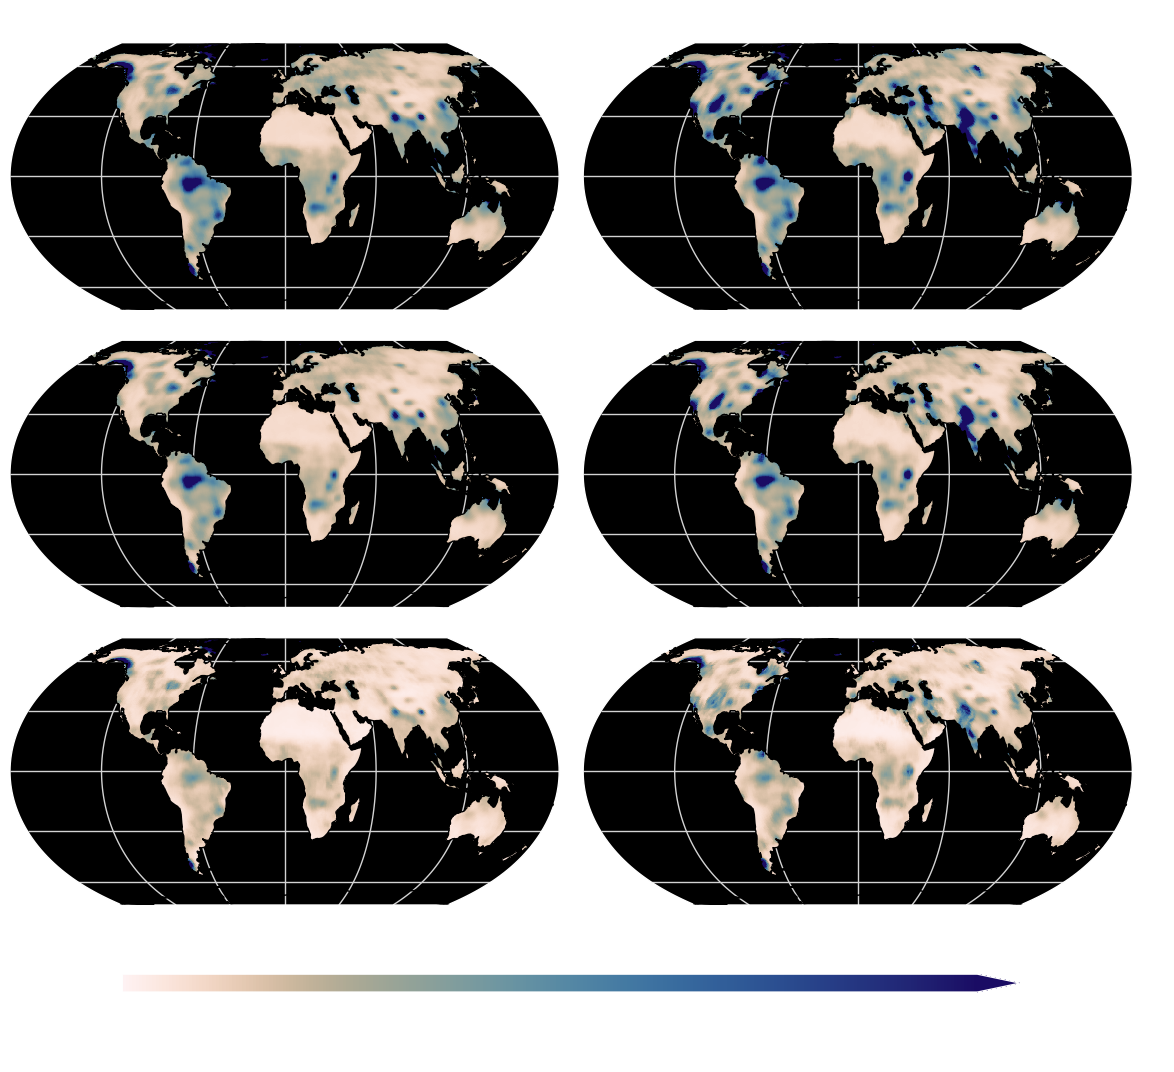

In [8]:
plot_kwargs["cbar_kwargs"]["label"] = "Uncertainty (mm)"

p = da_sigma_timemean.dr.projplot(
    col="model",
    row="component",
    vmin=0,
    vmax=120,
    cmap=cmc.lapaz_r,
    figsize=(6, 6),
    **plot_kwargs,
)
p.set_titles("{value}")

p.fig.savefig(FIGURE_DIR / "uncertainty_timeavg.pdf", backend="pgf")

## Aleatoric/Epistemic Ratio

Uncertainty ratio:

$$ \frac{\sigma^2_\text{ale}}{\sigma^2_\text{epi}} $$

In [9]:
da_vari = da_sigma_notna**2
vari_ratio = da_vari.sel(component="Aleatoric") / da_vari.sel(component="Epistemic")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/p2/9yn4fz8d3c12132tg5cwyrvh0000gp/T/ipykernel_14146/1273024517.py:2: SyntaxWarning: invalid escape sequence '\s'
  "Uncertainty Ratio $ \sigma^2_{ale} / \sigma^2_{epi}$"
/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


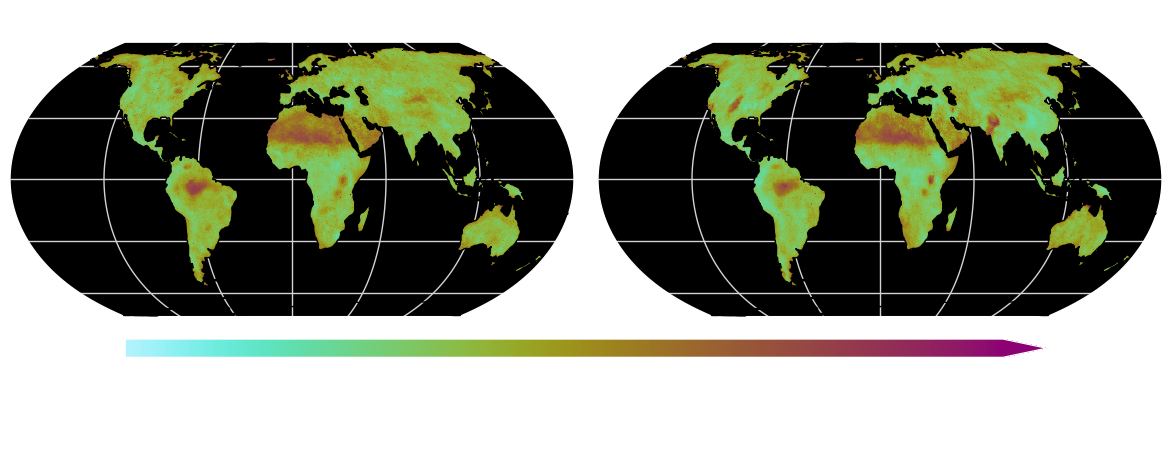

In [10]:
plot_kwargs["cbar_kwargs"]["label"] = (
    "Uncertainty Ratio $ \sigma^2_{ale} / \sigma^2_{epi}$"
)

p = vari_ratio.mean("time").dr.projplot(
    col="model",
    vmin=1,
    vmax=100,
    norm=colors.LogNorm(),
    cmap=cmc.hawaii_r,
    figsize=(6.0, 2.1),
    **plot_kwargs,
)
p.set_titles("{value}")

p.fig.savefig(FIGURE_DIR / "uncertainty_ratio.pdf", backend="pgf")


## Time series

/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


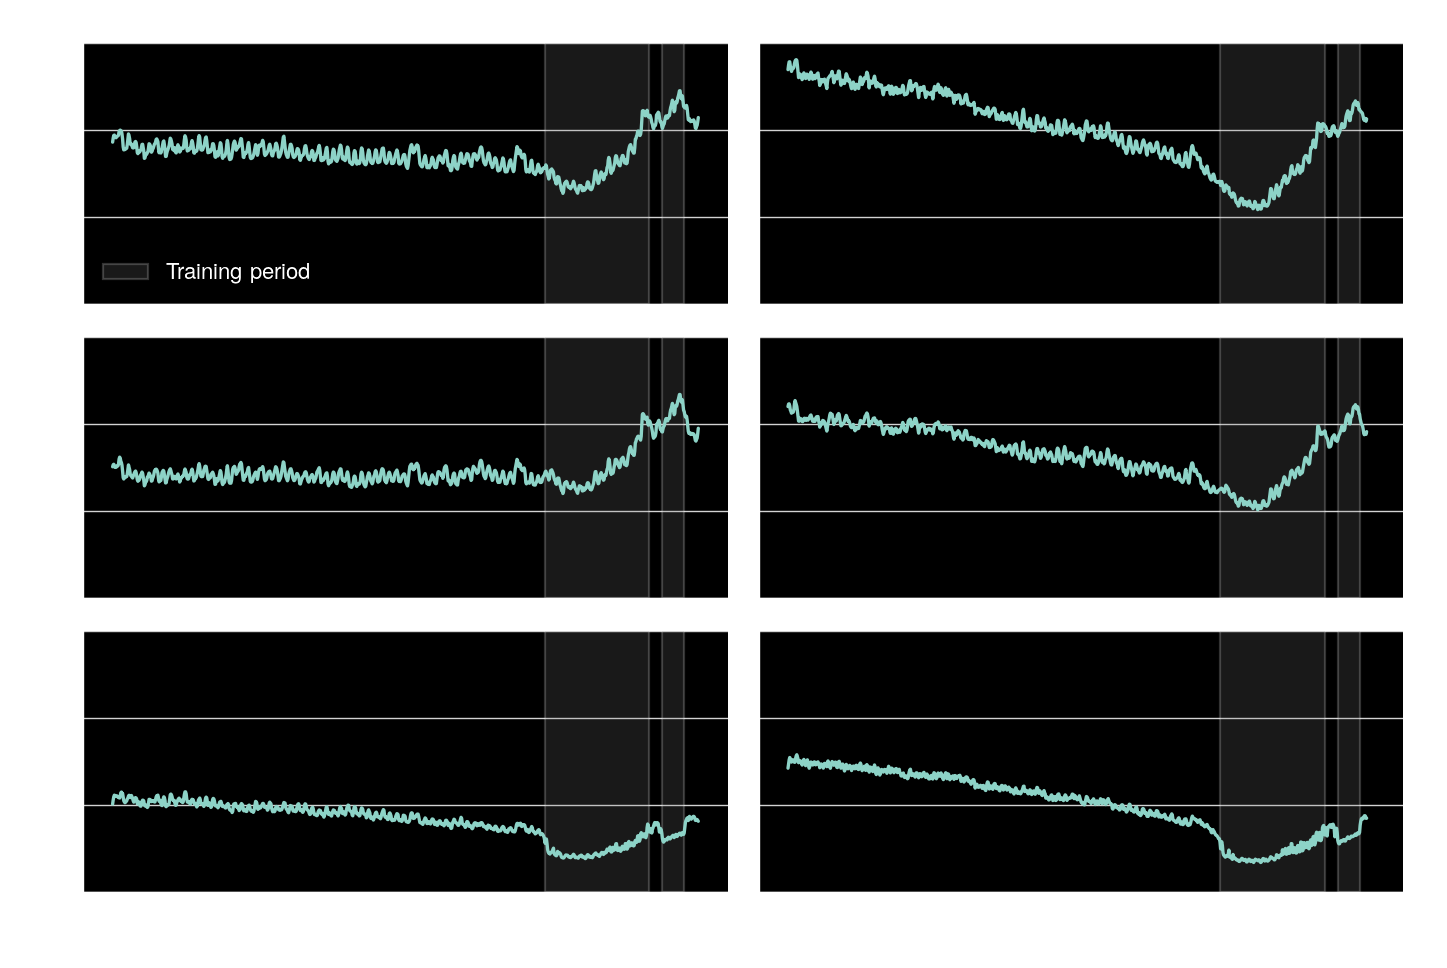

In [11]:
p = (
    da_sigma.dr.weight_lat()
    .mean(["lat", "lon"])
    .plot(col="model", row="component", figsize=(7.2, 5.0))
)
for ax in p.axs.flat:
    ax.set(ylim=(0, 60), xlabel=None)
for ax in p.axs[:, 0]:
    ax.set(ylabel="Uncertainty (mm)")

for i, ax in enumerate(p.axs.flat):
    ax.yaxis.grid()
    # Add training time
    label = "Training period" if i == 0 else None
    ax.axvspan(
        pd.Timestamp("2002-03-01"),
        pd.Timestamp("2017-01-01"),
        facecolor="tab:gray",
        alpha=0.2,
        label=label,
    )
    ax.axvspan(
        pd.Timestamp("2018-11-01"),
        pd.Timestamp("2021-12-01"),
        facecolor="tab:gray",
        alpha=0.2,
    )
    if i == 0:
        ax.legend(loc="lower left")

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")
p.set_titles(template="{value}")

p.fig.savefig(FIGURE_DIR / "uncertainty_globalavg.pdf", backend="pgf")